In [51]:
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import src
from warnings import filterwarnings
# Pandas will give a lot of warning while I am mutating data frames in functions.
filterwarnings('ignore')
# Matplot lib inline
%matplotlib inline

In [50]:
df_gross = pd.read_csv('../zippedData/bom.movie_gross.csv.gz')
df_genre = pd.read_csv('./basics-ratings-genre.csv')
df_budgets = pd.read_csv('../zippedData/tn.movie_budgets.csv.gz')

In [53]:
# perform a join on genres left on primary_title right on movie
df =df_genre.merge(df_budgets, how='inner', left_on='primary_title', right_on='movie')

# change the money columns to float. Create a function to do this
df.worldwide_gross=df.worldwide_gross.str.replace("$", "").str.replace(",",'').astype(float)
df.production_budget=df.production_budget.str.replace("$", "").str.replace(",",'').astype(float)
df.domestic_gross=df.domestic_gross.str.replace("$", "").str.replace(",",'').astype(float)
df.head(3)

,tconst,primary_title,genres,numvotes,averagerating,start_year,runtime_minutes,Sci-Fi,Fantasy,Horror,...,History,Game-Show,News,Romance,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt0249516,Foodfight!,"['Action', 'Animation', 'Comedy']",8248,1.9,2012,91.0,False,False,False,...,False,False,False,False,26,"Dec 31, 2012",Foodfight!,45000000.0,0.0,73706.0
1,tt0337692,On the Road,"['Adventure', 'Drama', 'Romance']",37886,6.1,2012,124.0,False,False,False,...,False,False,False,True,17,"Mar 22, 2013",On the Road,25000000.0,720828.0,9313302.0
2,tt0359950,The Secret Life of Walter Mitty,"['Adventure', 'Comedy', 'Drama']",275300,7.3,2013,114.0,False,False,False,...,False,False,False,False,37,"Dec 25, 2013",The Secret Life of Walter Mitty,91000000.0,58236838.0,187861183.0


In order to maximise the over lap in the columns, I want to first make sure that I have cleaned the columns as best as I possibly can. I predict that the since there is signeficantly more similarity in size between the genres df and the budgets, I should start there.

In [19]:
def dict_to_pandas(dictionary):
    return pd.DataFrame.from_dict(dictionary, orient='index')

# generate a genre set of all genres present in the df
def genre_set_list(df):
    all_genres = list(df.genres)
    return list(set([item for sublist in all_genres for item in sublist]))

def genre_pandas_mean(df, feature, genre_list):
    feature_dict = {}
    for genre in genre_list:
        feature_dict.update({genre:df[df[f'{genre}'] == True][f'{feature}'].median()})
        # Sort dictionary by value
    return dict_to_pandas({k: v for k, v in sorted(feature_dict.items(), key=lambda item: item[1],reverse=True)})
    

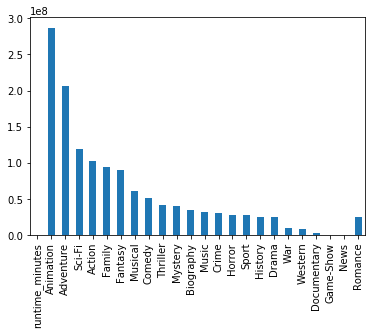

In [20]:
genre_list = list(df_genre.columns)[6:]
(genre_pandas_mean(df, 'worldwide_gross', genre_list)).plot(kind='bar', legend=False);

#### We have missing data for news and Game-show
This is unfortunate because there is a macro trend that these are very popular genres. It would be great to find some examples of news and game-shows and get there budgets. But for the purposes of our current analysis we can drop those columns if there are no true values. 

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1788 entries, 0 to 1787
Data columns (total 36 columns):
tconst               1788 non-null object
primary_title        1788 non-null object
genres               1788 non-null object
numvotes             1788 non-null int64
averagerating        1788 non-null float64
start_year           1788 non-null int64
runtime_minutes      1788 non-null float64
Sci-Fi               1788 non-null bool
Fantasy              1788 non-null bool
Horror               1788 non-null bool
Animation            1788 non-null bool
Mystery              1788 non-null bool
Musical              1788 non-null bool
Family               1788 non-null bool
Adventure            1788 non-null bool
War                  1788 non-null bool
Biography            1788 non-null bool
Comedy               1788 non-null bool
Thriller             1788 non-null bool
Crime                1788 non-null bool
Music                1788 non-null bool
Documentary          1788 non-null bool

In [22]:
df.columns = [x.lower() for x in df.columns]

In [23]:
df.drop(columns=['game-show', 'news'], inplace=True)

In [24]:
list(df.columns)[7:-7]

['sci-fi',
 'fantasy',
 'horror',
 'animation',
 'mystery',
 'musical',
 'family',
 'adventure',
 'war',
 'biography',
 'comedy',
 'thriller',
 'crime',
 'music',
 'documentary',
 'sport',
 'western',
 'drama',
 'action',
 'history']

In [25]:
df.head()

,tconst,primary_title,genres,numvotes,averagerating,start_year,runtime_minutes,sci-fi,fantasy,horror,...,drama,action,history,romance,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt0249516,Foodfight!,"['Action', 'Animation', 'Comedy']",8248,1.9,2012,91.0,False,False,False,...,False,True,False,False,26,"Dec 31, 2012",Foodfight!,45000000.0,0.0,7.370600e+04
1,tt0337692,On the Road,"['Adventure', 'Drama', 'Romance']",37886,6.1,2012,124.0,False,False,False,...,True,False,False,True,17,"Mar 22, 2013",On the Road,25000000.0,720828.0,9.313302e+06
2,tt0359950,The Secret Life of Walter Mitty,"['Adventure', 'Comedy', 'Drama']",275300,7.3,2013,114.0,False,False,False,...,True,False,False,False,37,"Dec 25, 2013",The Secret Life of Walter Mitty,91000000.0,58236838.0,1.878612e+08
3,tt0365907,A Walk Among the Tombstones,"['Action', 'Crime', 'Drama']",105116,6.5,2014,114.0,False,False,False,...,True,True,False,False,67,"Sep 19, 2014",A Walk Among the Tombstones,28000000.0,26017685.0,6.210859e+07
4,tt0369610,Jurassic World,"['Action', 'Adventure', 'Sci-Fi']",539338,7.0,2015,124.0,True,False,False,...,False,True,False,False,34,"Jun 12, 2015",Jurassic World,215000000.0,652270625.0,1.648855e+09


In [26]:

genre_pandas_mean(df, 'worldwide_gross', list(df.columns)[7:-5])).plot(kind='bar', legend=False;

SyntaxError: invalid syntax (<ipython-input-26-8c46b499f09f>, line 2)

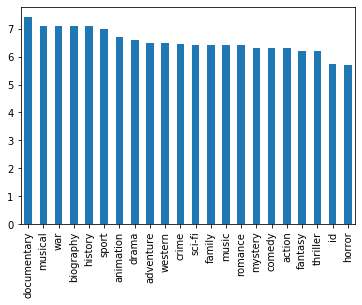

In [27]:
(genre_pandas_mean(df, 'averagerating', list(df.columns)[7:-5])).plot(kind='bar', legend=False);

### Rating is a terrible indicator for revenue prediction by genre

But what about the ROI as determined by the worldwide gross/total budget


In [28]:
df['roi'] = (df.worldwide_gross-df.production_budget)/df.production_budget*100

In [29]:
df.roi

0       -99.836209
1       -62.746792
2       106.440860
3       121.816382
4       666.909239
           ...    
1783    613.105500
1784     33.074300
1785     35.849094
1786    -28.559873
1787    201.793683
Name: roi, Length: 1788, dtype: float64

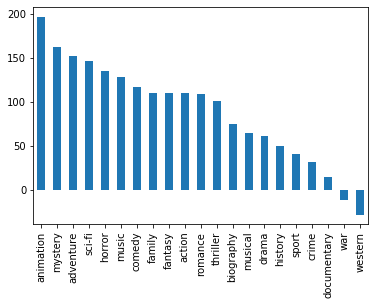

In [30]:
(genre_pandas_mean(df, 'roi', list(df.columns)[7:-7])).plot(kind='bar', legend=False);

In [31]:
to_drop = ["id", 'start_year']
df.drop(columns=to_drop, inplace = True)

In [32]:
df.head()

,tconst,primary_title,genres,numvotes,averagerating,runtime_minutes,sci-fi,fantasy,horror,animation,...,drama,action,history,romance,release_date,movie,production_budget,domestic_gross,worldwide_gross,roi
0,tt0249516,Foodfight!,"['Action', 'Animation', 'Comedy']",8248,1.9,91.0,False,False,False,True,...,False,True,False,False,"Dec 31, 2012",Foodfight!,45000000.0,0.0,7.370600e+04,-99.836209
1,tt0337692,On the Road,"['Adventure', 'Drama', 'Romance']",37886,6.1,124.0,False,False,False,False,...,True,False,False,True,"Mar 22, 2013",On the Road,25000000.0,720828.0,9.313302e+06,-62.746792
2,tt0359950,The Secret Life of Walter Mitty,"['Adventure', 'Comedy', 'Drama']",275300,7.3,114.0,False,False,False,False,...,True,False,False,False,"Dec 25, 2013",The Secret Life of Walter Mitty,91000000.0,58236838.0,1.878612e+08,106.440860
3,tt0365907,A Walk Among the Tombstones,"['Action', 'Crime', 'Drama']",105116,6.5,114.0,False,False,False,False,...,True,True,False,False,"Sep 19, 2014",A Walk Among the Tombstones,28000000.0,26017685.0,6.210859e+07,121.816382
4,tt0369610,Jurassic World,"['Action', 'Adventure', 'Sci-Fi']",539338,7.0,124.0,True,False,False,False,...,False,True,False,False,"Jun 12, 2015",Jurassic World,215000000.0,652270625.0,1.648855e+09,666.909239


### Create a new dataframe with a multi-index 

How do I cluster my data into low, low budget, medium and high budget?

In [33]:

def get_iqr(df, col_name):
    hq = df[col_name].quantile(0.75) 
    median = df[col_name].quantile(0.5)
    lq = df[col_name].quantile(0.25)
    iqr = hq-lq
    return iqr, median

def is_outlier(x, iqr, median):
    if x > median + iqr*1.5:
        return True
    elif x < median - 1.5*iqr:
        return True
    else:
        return False

def find_outliers(df, column):
    """
    Returns a boolean series. True if outside IQR*1.5 range, False otherwise
    """
    IQR , median  = get_iqr(df, column)
    return df[column].apply(lambda x: is_outlier(x, IQR, median))

          
def categorize_production(x):
    m = int(x)
    if m < df['production_budget'].quantile(0.25):
        return 'small'
    elif m > df['production_budget'].quantile(0.75): 
        return 'large'
    else:
        return 'medium'
    


In [34]:
df_outlier = df.copy()

In [35]:
df_outlier.outlier.value_counts()

AttributeError: 'DataFrame' object has no attribute 'outlier'

In [36]:
# find outliers
df['outlier'] = find_outliers(df, 'roi')
df.outlier.value_counts()
df = df[df.outlier == 0]

In [37]:
df['production_size']=df.production_budget.apply(lambda x: categorize_production(x))

In [38]:
df.production_size.value_counts()

medium    809
small     393
large     380
Name: production_size, dtype: int64

In [39]:
df_top_100 = df.sort_values('worldwide_gross', ascending=False)[:100]
genres = df_top_100.columns[7:-9]

In [54]:
df_to_plot = genre_pandas_mean(df, 'roi', genres)

KeyError: 'fantasy'

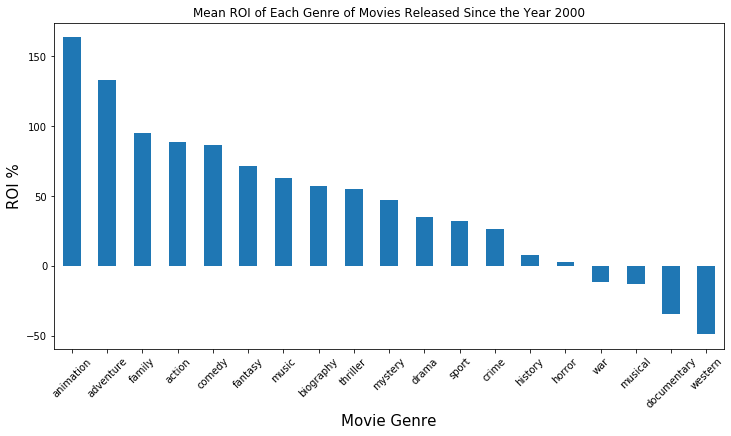

In [41]:
df_to_plot.plot(kind='bar', legend=False,figsize=(12,6))
plt.xticks(rotation = 45)
plt.title('Mean ROI of Each Genre of Movies Released Since the Year 2000')
plt.ylabel('ROI %', size = 15)
plt.xlabel('Movie Genre', size = 15);

Outlier analysis. Time series. Combination effect.

In [323]:
# convert a listy string to a list
def string_to_list(df, column):
    things = ["'", "[","]"]
    for thing in things:
        df[column] = df[column].apply(lambda x: x.replace(f"{thing}",""))
    return df[column].apply(lambda x: [x.strip() for x in x.split(",")])

def list_to_string(df, column):
    return df[column].apply(lambda x: " ".join(x))

In [324]:
# df_outliers.genres =string_to_list(df, 'genres')

In [367]:
df_outliers.sort_values('roi', ascending=False)[:26].groupby(['genres']).tconst.count().sort_values(ascending=False)

genres
['Horror', 'Mystery', 'Thriller']       9
['Horror', 'Thriller']                  4
['Horror']                              2
['Drama']                               2
['Family', 'Fantasy', 'Musical']        1
['Drama', 'Horror', 'Thriller']         1
['Drama', 'Horror', 'Mystery']          1
['Drama', 'Fantasy', 'Romance']         1
['Drama', 'Family', 'Fantasy']          1
['Crime', 'Drama', 'Family']            1
['Biography', 'Drama', 'History']       1
['Adventure', 'Animation', 'Comedy']    1
['Action', 'Biography', 'Drama']        1
Name: tconst, dtype: int64

In [326]:
df.outlier.value_counts()

False    1602
Name: outlier, dtype: int64

In [327]:
df_outliers['len'] = df_outliers.genres.apply(lambda x: len(x))

In [328]:
df_outliers = df_outliers[df.len > 1]

AttributeError: 'DataFrame' object has no attribute 'len'

In [ ]:
df_outliers.genres=list_to_string(df_outliers, 'genres')

In [368]:
df_outliers.sort_values('roi').primary_title[:100]

149                  Alice in Wonderland
1468                The Walking Deceased
1253                     Ask Me Anything
113                         Freaky Deaky
575                          Point Blank
                      ...               
1349                        Higher Power
881                          Inescapable
515     Eddie: The Sleepwalking Cannibal
1453               10 Days in a Madhouse
548                              Area 51
Name: primary_title, Length: 100, dtype: object